<p align="center">
  <br/>
    <a href="https://stabrise.com/scaledp/"><img alt="ScaleDP" src="https://raw.githubusercontent.com/StabRise/ScaleDP/refs/heads/master/images/scaledp.webp" width="376" style="max-width: 100%;"></a>
  <br/>
</p>

<p align="center">
    <i>An Open-Source Library for Processing Documents using AI/ML in Apache Spark.</i>
</p>

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/scaledp-tutorials/blob/master/object-detection/1.YoloOnnxDetector.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://github.com/stabrise/scaledp/" alt="GitHub"><img src="https://img.shields.io/static/v1?label=GitHub&message=ScaleDP&color=blue&logo=github" /></a>
    <a href="https://pypi.org/project/scaledp/" alt="Package on PyPI"><img src="https://img.shields.io/pypi/v/scaledp.svg" /></a>    
    <a href="https://github.com/stabrise/scaledp/blob/main/LICENSE"><img alt="GitHub" src="https://img.shields.io/github/license/stabrise/scaledp.svg?color=blue"></a>
    <a href="https://stabrise.com"><img alt="StabRise" src="https://img.shields.io/badge/by-StabRise-orange.svg?style=flat&colorA=E1523D&colorB=blue"></a>
    <a href="https://scaledp.stabrise.com/en/latest/"><img src="https://app.readthedocs.org/projects/scaledp/badge/?version=latest" alt="Documentation Status"/></a>
</p>

# Object detection using Yolo models in ScaleDP

- Inference using ONNX model for object detection (no needPyTorch/TensorFlow
installation)

[More details about YoloOnnxDetector](https://scaledp.stabrise.com/en/latest/models/detectors/yolo_onnx_detector.html)


## Installation

Required Java 8

### Automatically install Java 8 if run on Google Colab

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [ ]:
import os
import sys

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
!pip install scaledp

## Prepare model for run in ScaleDP

### Install ultralytics

In [ ]:
# Need only for export model
!pip install ultralytics

### Load model and get labels

In [1]:
from ultralytics import YOLO

# Load model (weights can be custom or pretrained)
model = YOLO("yolo11n.pt")  # or yolov9n.pt

label_list = list(model.names.values())
print(label_list)

WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at '/home/mykola/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pi

### Export model to the ONNX format

In [2]:
model.export(format="onnx")

Ultralytics 8.3.226 🚀 Python-3.11.11 torch-2.6.0+cpu CPU (13th Gen Intel Core(TM) i9-13980HX)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.4 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.73...
ONNX: export success ✅ 0.9s, saved as 'yolo11n.onnx' (10.2 MB)

Export complete (1.1s)
Results saved to /home/mykola/PycharmProjects/scaledp/tutorials/object-detection
Predict:         yolo predict task=detect model=yolo11n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolo11n.onnx imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


'yolo11n.onnx'

### Check that model is exported

In [16]:
!ls yolo*

yolo11n.onnx  yolo11n.pt


## Start Spark Session with ScaleDP and Spark PDF Data Source

In [6]:
from scaledp import *

spark = ScaleDPSession(with_spark_pdf=True)
spark

## Read PDF file to the DataFrame

In [ ]:
!wget https://raw.githubusercontent.com/StabRise/ScaleDP-Tutorials/master/data/pdfs/SampleWithFace.pdf -O SampleWithFace.pdf

In [3]:
pdf_example = './SampleWithFace.pdf'

df = spark.read.format("pdf") \
    .load(pdf_example)

df.show()

Estimating resolution as 397                                        (0 + 1) / 1]


+--------------------+------------------+-----------+----------------+--------------------+--------------------+--------------------+
|                path|          filename|page_number|partition_number|                text|               image|            document|
+--------------------+------------------+-----------+----------------+--------------------+--------------------+--------------------+
|file:///home/myko...|SampleWithFace.pdf|          0|               0| \nhttps://stabri...|{file:///home/myk...|{file:///home/myk...|
+--------------------+------------------+-----------+----------------+--------------------+--------------------+--------------------+



In [4]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- page_number: integer (nullable = true)
 |-- partition_number: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- path: string (nullable = true)
 |    |-- resolution: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |    |-- imageType: string (nullable = true)
 |    |-- exception: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |-- document: struct (nullable = true)
 |    |-- path: string (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- outputType: string (nullable = true)
 |    |-- bBoxes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |    |    |-- score: float (nullable = true)
 |    |    |    |-- x: integer (nullable = true)
 |    |    |    |-- y: intege

## Show PDF File as image

Image#:,0
Path:,SampleWithFace.pdf
Size:,0 x 0 px
Resolution:,300 dpi

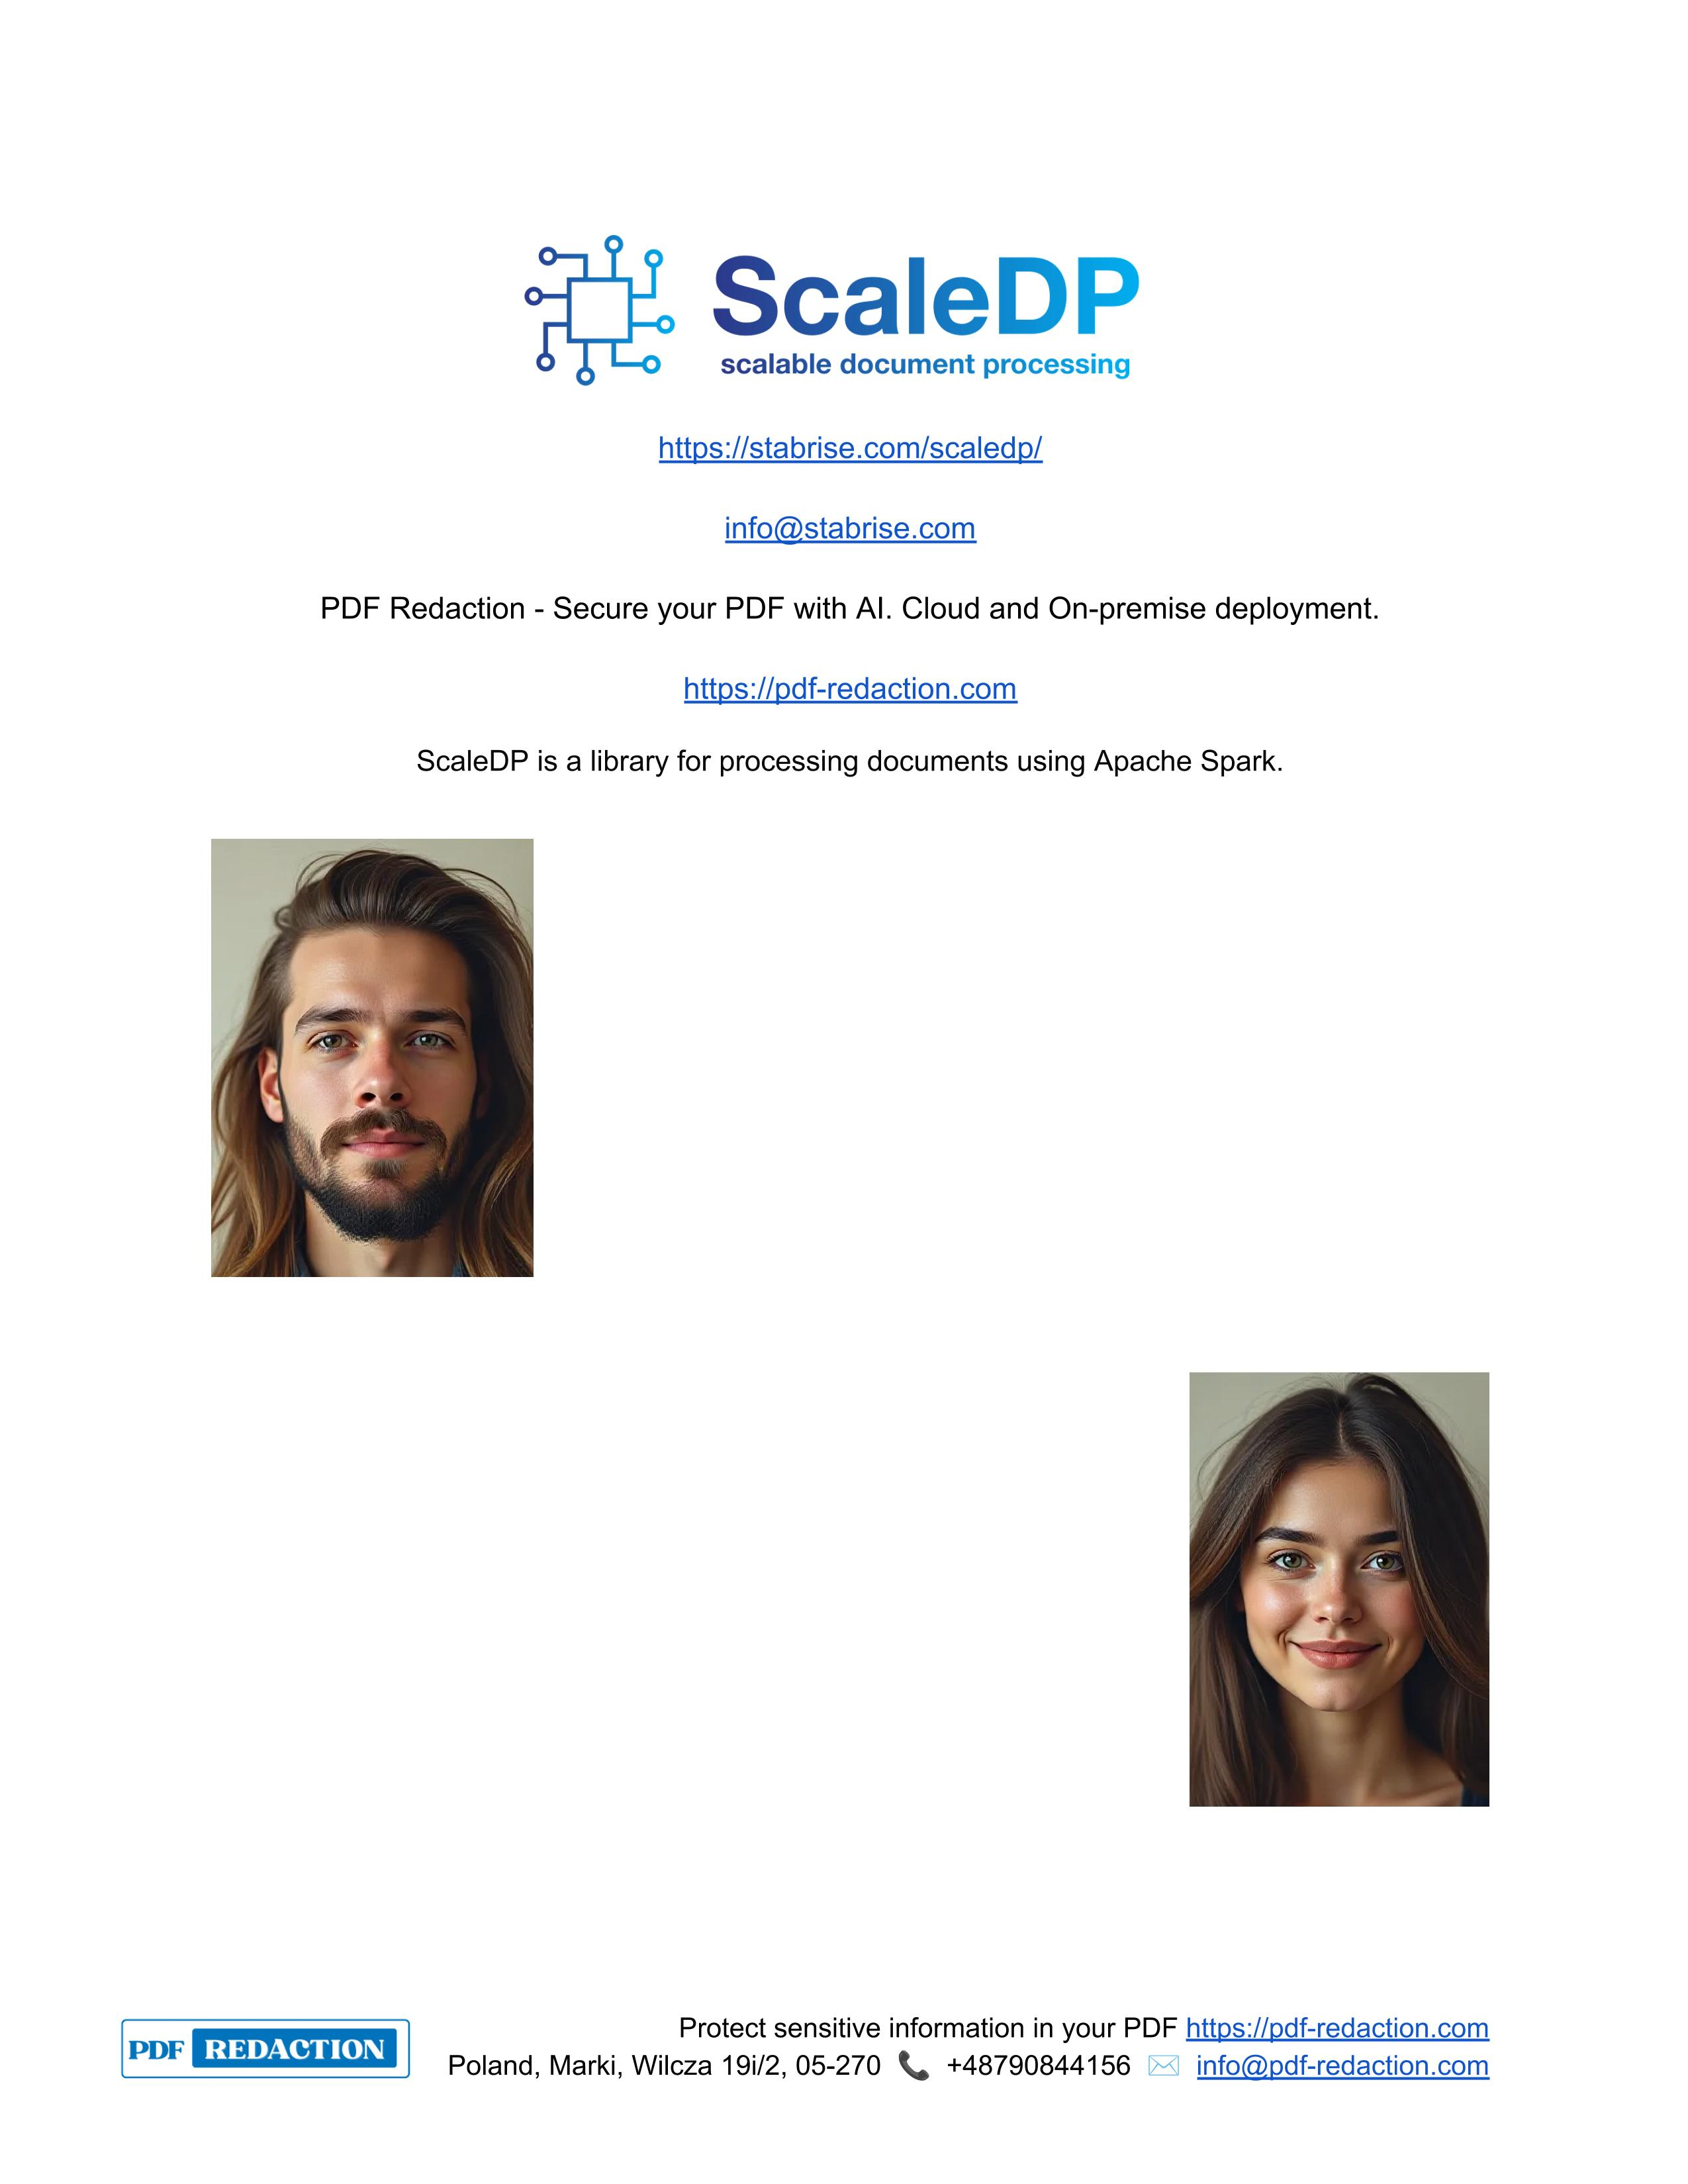

In [5]:
df.show_image()

## Define pipeline with yolo YoloOnnxDetector

In [9]:
pipeline = PipelineModel(stages=[
    YoloOnnxDetector(
        keepInputData=True,
        partitionMap=True,
        numPartitions=0,
        task="detect",
        model="yolo11n.onnx",
        scoreThreshold=0.6,
        labels=label_list,
    ),
    ImageDrawBoxes(
        keepInputData=True,
        inputCols=["image", "boxes"],
        outputCol="image_with_boxes",
        filled=False,
        color="red",
        lineWidth=5,
        textSize=34,
        displayDataList=["text", "score"],
    )
])

## Run pipeline and show results dataframe

In [10]:
results = pipeline.transform(df)

results.select("boxes.bboxes").show(1, False)

+----------------------------------------------------------------------------------------------------------------+
|bboxes                                                                                                          |
+----------------------------------------------------------------------------------------------------------------+
|[{person, 0.911443829536438, 310, 1282, 494, 638, 0.0}, {person, 0.8633673191070557, 1794, 2089, 440, 634, 0.0}]|
+----------------------------------------------------------------------------------------------------------------+



In [11]:
results.printSchema()

root
 |-- path: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- page_number: integer (nullable = true)
 |-- partition_number: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- path: string (nullable = true)
 |    |-- resolution: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |    |-- imageType: string (nullable = true)
 |    |-- exception: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |-- document: struct (nullable = true)
 |    |-- path: string (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- outputType: string (nullable = true)
 |    |-- bBoxes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |    |    |-- score: float (nullable = true)
 |    |    |    |-- x: integer (nullable = true)
 |    |    |    |-- y: intege

## Explore detected face bounding boxes

In [20]:
from pyspark .sql.functions import explode
results.select(explode("boxes.bboxes")).show(10, False)

+-------------------------------------------------------+
|col                                                    |
+-------------------------------------------------------+
|{person, 0.911443829536438, 310, 1282, 494, 638, 0.0}  |
|{person, 0.8633673191070557, 1794, 2089, 440, 634, 0.0}|
+-------------------------------------------------------+



## Display image with detected boxes

Image#:,0
Path:,SampleWithFace.pdf
Size:,2550 x 3299 px
Resolution:,300 dpi

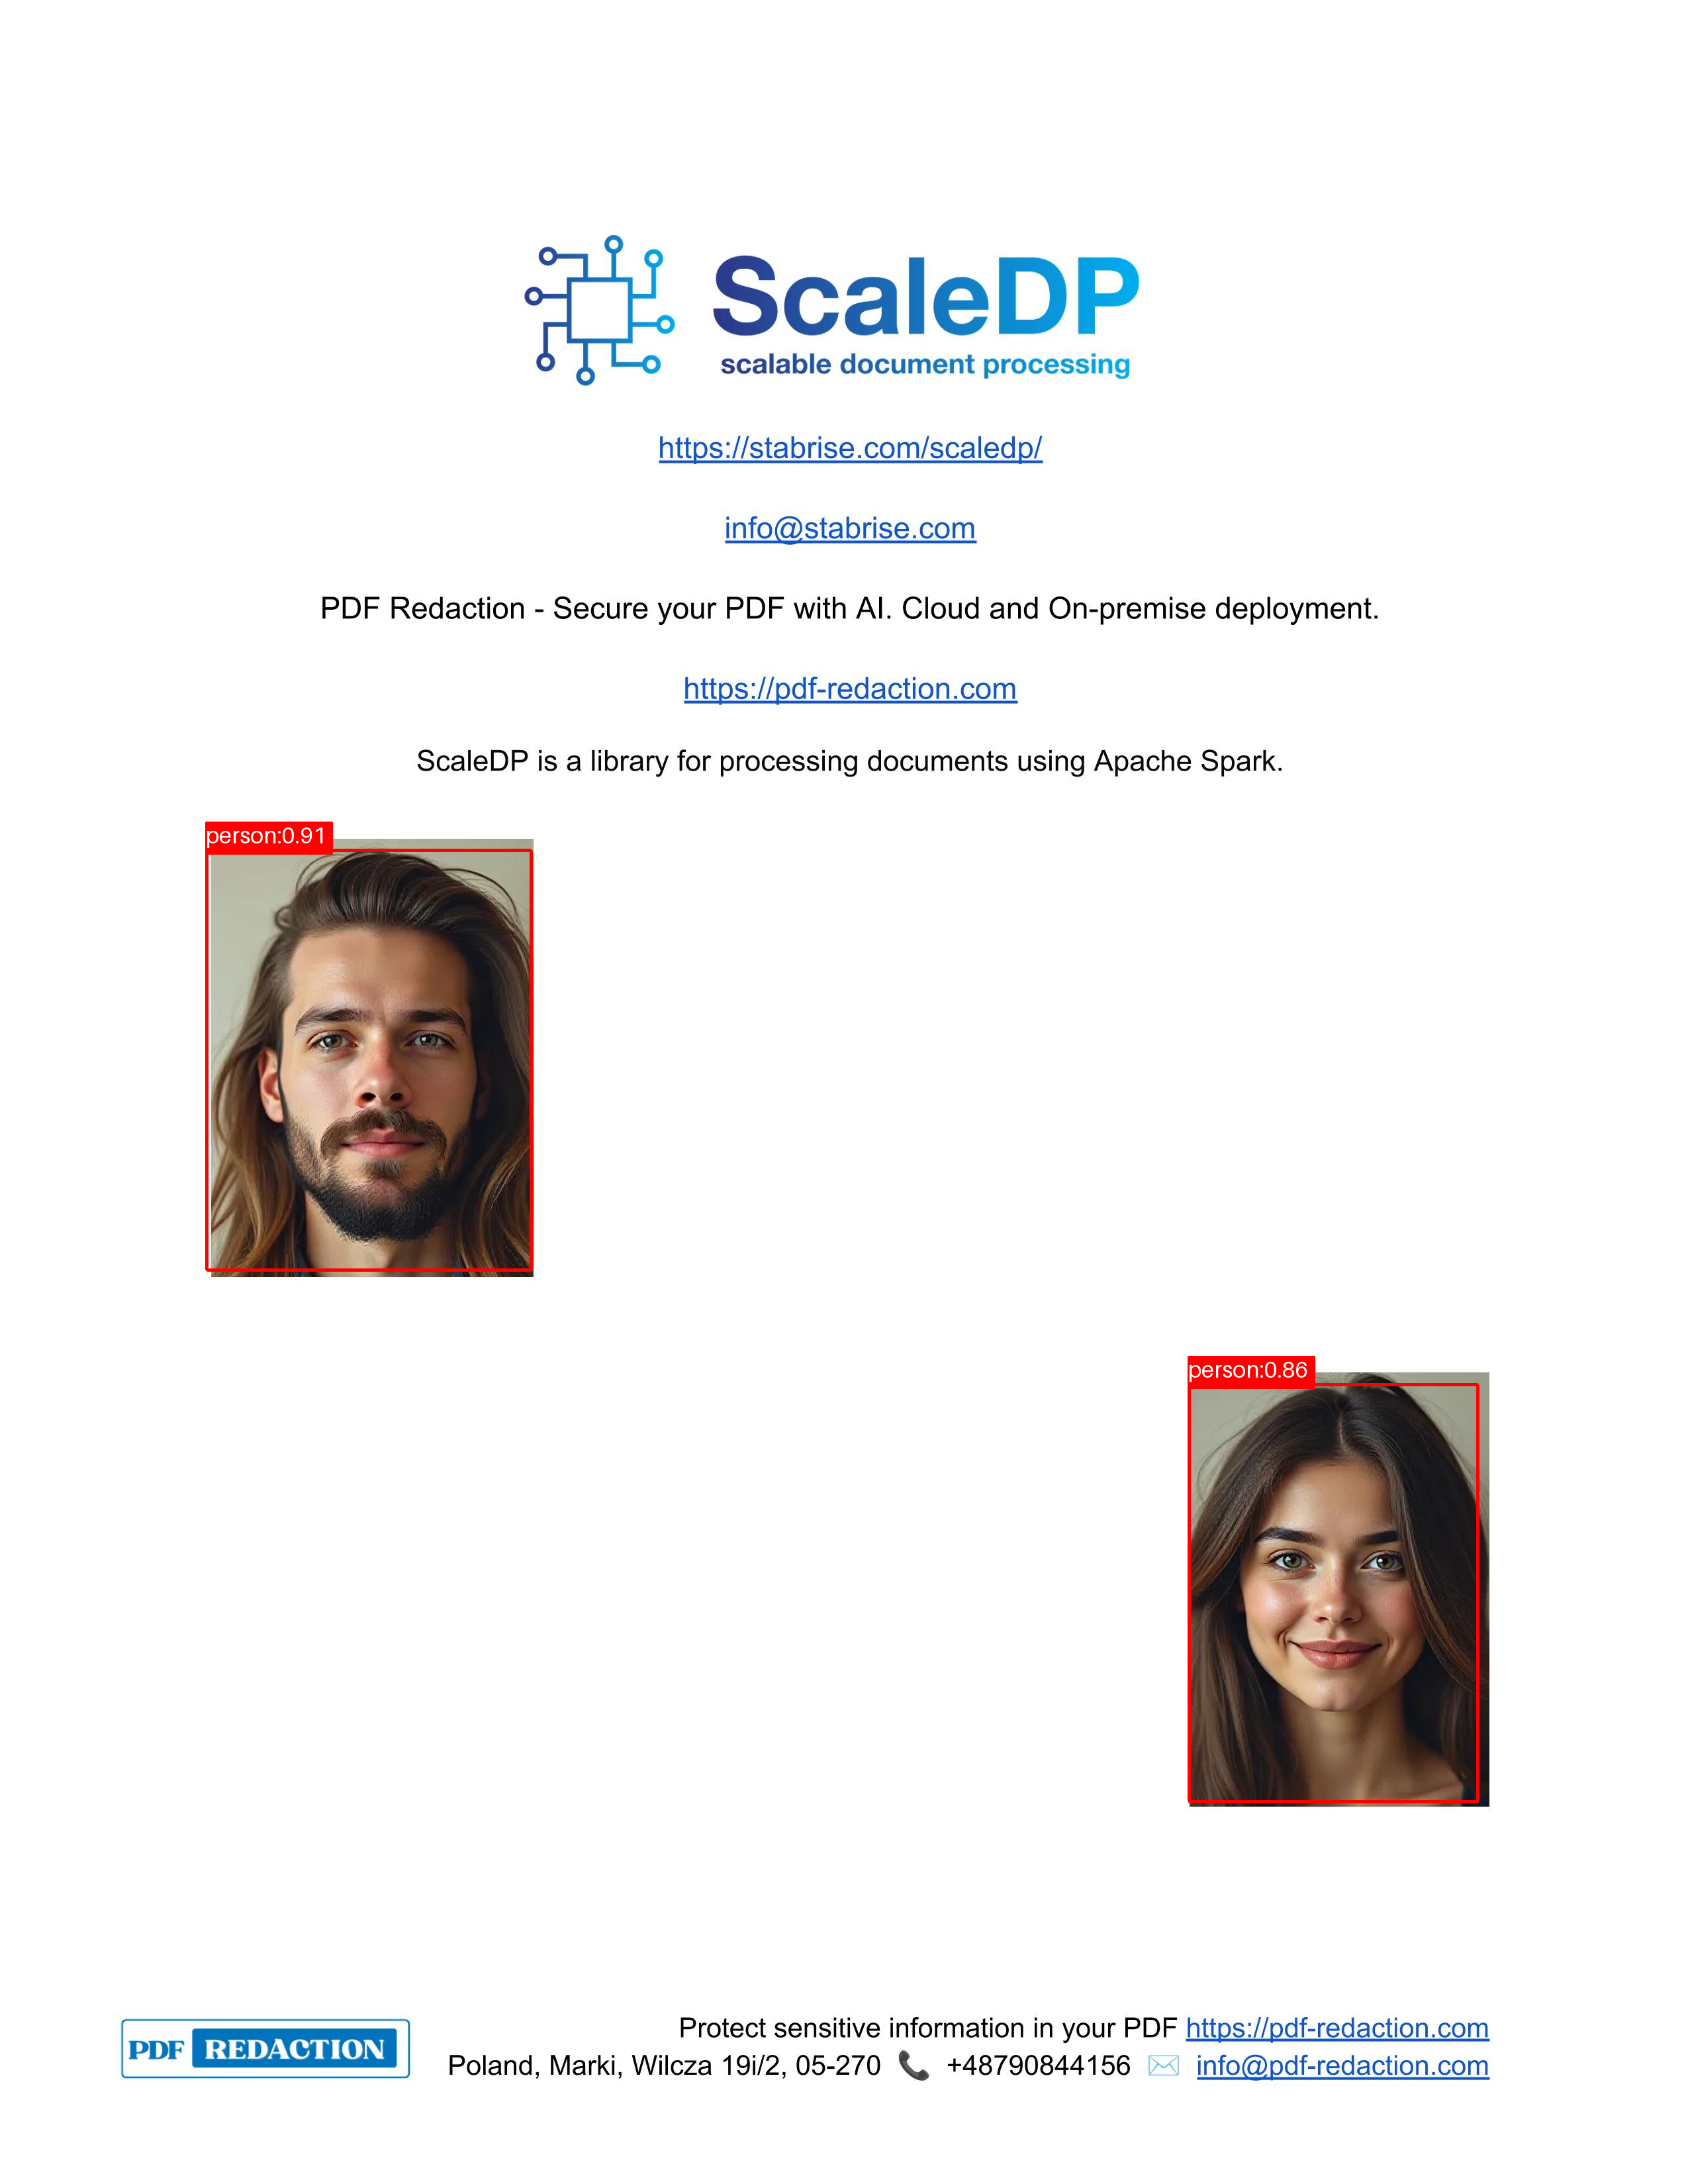

In [21]:
results.show_image("image_with_boxes")

## Crop detected objects from the image and display them

Estimating resolution as 397


Image#:,0
Path:,SampleWithFace.pdf
Size:,494 x 638 px
Resolution:,300 dpi

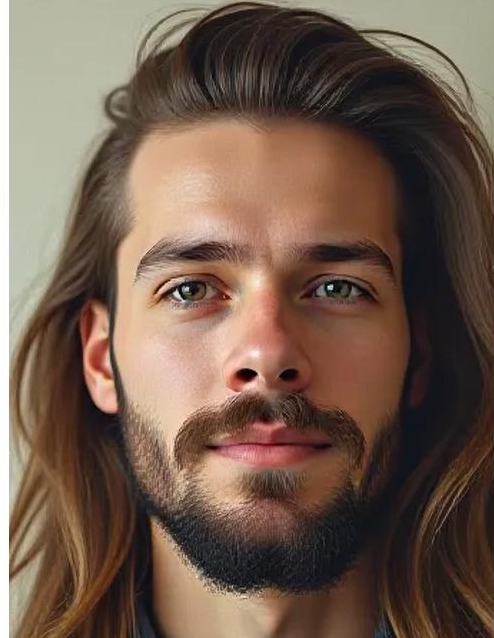

Image#:,1
Path:,SampleWithFace.pdf
Size:,440 x 634 px
Resolution:,300 dpi

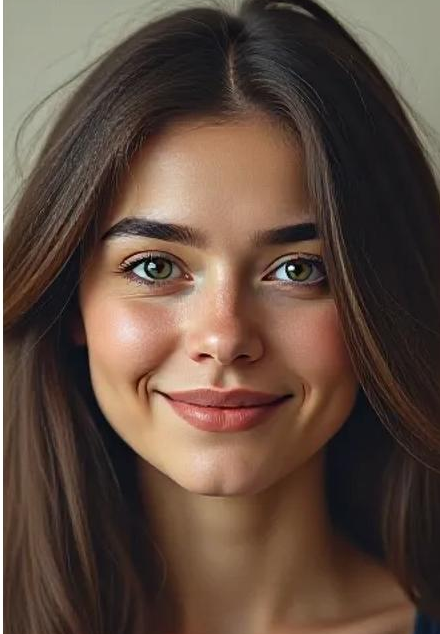

In [22]:
result_croped = ImageCropBoxes(inputCols=["image", "boxes"], autoRotate=False) \
    .transform(results) \
    .cache()
result_croped.show_image("cropped_image", limit=10, width=200)